In [55]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import torchvision
import torchvision.models as models
from torchvision import *
from torchvision import datasets
from torchvision.models.feature_extraction import create_feature_extractor

from torchmetrics import *

from torch.utils.data import *

import sklearn as sk
from sklearn import *
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

from itertools import compress


import matplotlib.pyplot as plt


import yfinance as yf


In [72]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [71]:
# create a dataset out of timeseries data, must be formatted first, tensor
# correct timeseries formatation
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,i):
        return self.X[i], self.y[i]
    

In [62]:
#stock
stock_symbol = 'AAPL'
#downloads stock data
data = yf.download(stock_symbol, start="2019-01-01", end="2024-01-01",)

[*********************100%%**********************]  1 of 1 completed


In [67]:
#get close prices
close_prices = data['Close'].values.reshape(-1,1)
#normalizer
scaler = MinMaxScaler(feature_range=(0,1))
#transforms/normalizes data
close_prices_scaled = scaler.fit_transform(close_prices)

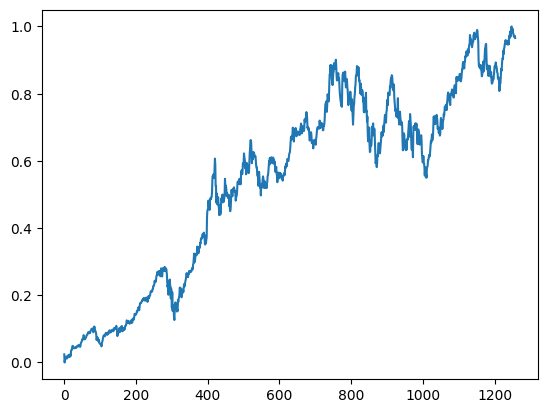

In [68]:
# plot data
close_prices.shape
plt.plot(close_prices_scaled)

In [ ]:
# get pairs trading data and use it 


In [244]:

#time step to predict ahead, creates input sequences
def create_lstm_data(data, time_step=1, gap = 0,test_percent = .1):
    x_vec, y_vec = [], []
    #formats data so y = t and x = t-1, ... , t-time_steps
    for i in range(len(data) - time_step):
        x_vec.append(normalized_data[i: (i + time_step), 0].unsqueeze(0))
        y_vec.append(normalized_data[(i + time_step), 0].unsqueeze(0))
    #calculate number of elements to allocate to test
    dataset_length = len(x_vec)
    num_of_train = dataset_length - (int)(test_percent * dataset_length)
    #concats x into matrix and y into vector, needs unsqueez to add single dimension for LSTM
    return torch.cat(x_vec[:num_of_train],0).unsqueeze(-1), torch.cat(y_vec[:num_of_train],0).unsqueeze(-1), torch.cat(x_vec[num_of_train:],0).unsqueeze(-1), torch.cat(y_vec[num_of_train:],0).unsqueeze(-1)

#time step to predict ahead, creates input sequences
def create_data_no_split(data, gap = 0,time_step=1):
    x_vec, y_vec = [], []
    #formats data so y = t and x = t-1, ... , t-time_steps
    for i in range(len(data) - time_step):
        x_vec.append(normalized_data[i: (i + time_step), 0].unsqueeze(0))
        y_vec.append(normalized_data[(i + time_step), 0].unsqueeze(0))
    #concats x into matrix and y into vector, needs unsqueez to add single dimension for LSTM
    return torch.cat(x_vec).unsqueeze(-1), torch.cat(y_vec).unsqueeze(-1)

In [210]:
class PairTradingLSTM(nn.Module):
    # initalize variables
    def __init__(self,input_len, hidden_size, num_layers,dropout = 0.5):
        super(PairTradingLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_len,hidden_size,num_layers,dropout=dropout,
                            batch_first = True)
        
        self.fc = nn.Linear(hidden_size, 1)
    # forward pass
    def forward(self,x):
        hidden_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        cell_states = torch.zeros(self.num_layers, x.size(0),self.hidden_size).to(device)
        
        out, _ = self.lstm(x.to(torch.float32),(hidden_states, cell_states))
        out = self.fc(out[:,-1,:])
        
        return out

In [194]:
def train_epoch(model,train_dataloader,loss_fn,optimizer):
    
    model.train()
    running_loss = 0.0

    for X, y in train_dataloader:
        X_train, y_train = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
        
        output = model(X_train)
        loss = loss_fn(output, y_train)
        running_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_loss = running_loss / len(train_dataloader)
    print(f'Train Average Loss: {avg_loss}')

In [204]:
def validate_epoch(model,validate_dataloader,loss_fn):
    
    #turn train mode off
    model.train(False)
    running_loss = 0.0

    for X, y in train_dataloader:
        X_train, y_train = X.to(device), y.to(device)
        #tell pytorch that gradients dont need to be computed
        with torch.inference_mode():
            output = model(X_train)
            loss = loss_fn(output, y_train)
            running_loss += loss
    avg_loss = running_loss / len(validate_dataloader)
    
    print(f'Validation Average Loss: {avg_loss}')

In [172]:
BATCH_SIZE = 64

In [235]:
close_prices = data['Close'].values.reshape(-1,1)
#need data inputed to be n x 1
scaler = MinMaxScaler(feature_range=(0,1))
#transforms/normalizes data and converts it to a tensor
normalized_data = torch.tensor(scaler.fit_transform(close_prices))
X_train, y_train, X_test, y_test = create_lstm_data(norm_data,7)
#creates dataset
train_dataset = TimeSeriesDataset(X_train,y_train)
test_dataset = TimeSeriesDataset(X_test,y_test)
#puts dataset into dataloader
train_dataloader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE)


(1126, 125)

In [185]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# initialize device
model = PairTradingLSTM(1,6,1)
model.to(device)

C:\Users\Nicko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


PairTradingLSTM(
  (lstm): LSTM(1, 6, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)

In [205]:
#training
learning_rate = 0.001
num_epochs = 10
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

for epoch in range(num_epochs):
    print(f'Epoch: {epoch}')
    
    train_epoch(model, train_dataloader, loss, optimizer)
    if (epoch % 5 == 0):
        validate_epoch(model, train_dataloader, loss)


Epoch: 0
Average Loss: 0.022193314507603645
Validation Average Loss: 0.014899750240147114
Epoch: 1
Average Loss: 0.010582651011645794
Epoch: 2
Average Loss: 0.011152737773954868
Epoch: 3
Average Loss: 0.008770163170993328
Epoch: 4
Average Loss: 0.006202549207955599
Epoch: 5
Average Loss: 0.004487730097025633
Validation Average Loss: 0.003233935683965683
Epoch: 6
Average Loss: 0.0031148374546319246
Epoch: 7
Average Loss: 0.002119367942214012
Epoch: 8
Average Loss: 0.0014915335923433304
Epoch: 9
Average Loss: 0.0011284415377303958


torch.Size([1126, 1])


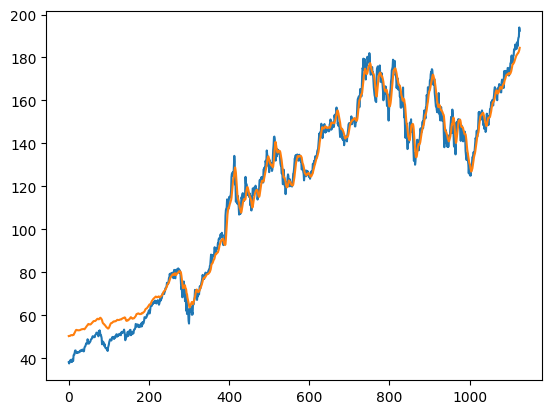

In [237]:
with torch.inference_mode():
    predicted = model(X_train.to(device).to(torch.float32)).to(device)

#y_train = format_back(y_train, 7)
#y_pred = format_back(predicted, 7)

print(f'{y_train.shape}')

true_y_train = scaler.inverse_transform(y_train)
true_y_pred = scaler.inverse_transform(predicted)

plt.plot(true_y_train, label = 'Actual Close')
plt.plot(true_y_pred, label = 'Predicted Close')



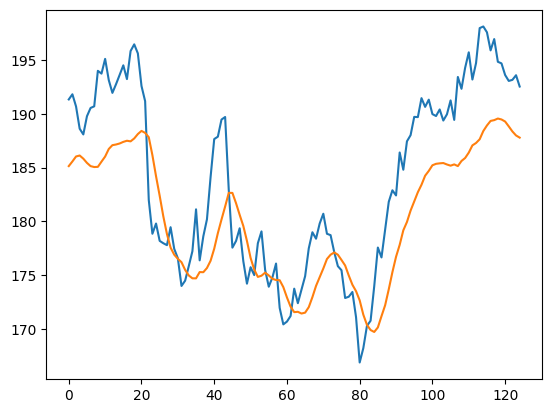

In [242]:
with torch.inference_mode():
    predicted = model(X_test.to(device).to(torch.float32)).to(device)

true_y_test = scaler.inverse_transform(y_test)
true_y_pred = scaler.inverse_transform(predicted)

plt.plot(true_y_test, label = 'Actual Close')
plt.plot(true_y_pred, label = 'Predicted Close')

PairsTrading Test

In [270]:
# Download stock data from Yahoo Finance
hmc_data = yf.download('HMC', period='10y')['Close']
hymtf_data = yf.download('HYMTF', period='10y')['Close']
spread = hmc_data - hymtf_data
spread = spread.values.reshape(-1,1)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [307]:
scaler = MinMaxScaler(feature_range=(0,1))
#transforms/normalizes data and converts it to a tensor
normalized_data = torch.tensor(scaler.fit_transform(spread))
X_train, y_train, X_test, y_test = create_lstm_data(norm_data,7)
#creates dataset
train_dataset = TimeSeriesDataset(X_train,y_train)
test_dataset = TimeSeriesDataset(X_test,y_test)
#puts dataset into dataloader
train_dataloader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE)

In [308]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# initialize device
pair_model = PairTradingLSTM(1,6,3)
pair_model = pair_model.to(device)

In [313]:

#training
learning_rate = 0.001
num_epochs = 50
loss = nn.MSELoss()
optimizer = torch.optim.Adam(pair_model.parameters(), learning_rate)

for epoch in range(num_epochs):
    print(f'Epoch: {epoch}')
    
    train_epoch(pair_model, train_dataloader, loss, optimizer)
    if (epoch % 5 == 0):
        validate_epoch(pair_model, test_dataloader, loss)

Epoch: 0
Average Loss: 0.021521707996726036
Validation Average Loss: 0.13229143619537354
Epoch: 1
Average Loss: 0.01739419624209404
Epoch: 2
Average Loss: 0.01753007434308529
Epoch: 3
Average Loss: 0.015892697498202324
Epoch: 4
Average Loss: 0.01455102488398552
Epoch: 5
Average Loss: 0.01279105618596077
Validation Average Loss: 0.07022616267204285
Epoch: 6
Average Loss: 0.012852150946855545
Epoch: 7
Average Loss: 0.011526557616889477
Epoch: 8
Average Loss: 0.011441619135439396
Epoch: 9
Average Loss: 0.011003026738762856
Epoch: 10
Average Loss: 0.010319520719349384
Validation Average Loss: 0.04745250195264816
Epoch: 11
Average Loss: 0.009521784260869026
Epoch: 12
Average Loss: 0.008674020878970623
Epoch: 13
Average Loss: 0.008797671645879745
Epoch: 14
Average Loss: 0.008108999580144882
Epoch: 15
Average Loss: 0.007983807474374771
Validation Average Loss: 0.03461315482854843
Epoch: 16
Average Loss: 0.007713524624705315
Epoch: 17
Average Loss: 0.006680547725409269
Epoch: 18
Average Loss: 

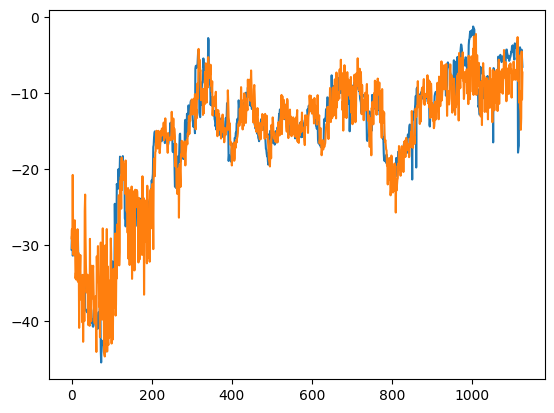

In [314]:
with torch.inference_mode():
    predicted = pair_model(X_train.to(device).to(torch.float32)).to(device)

true_y_train = scaler.inverse_transform(y_train)
true_y_pred = scaler.inverse_transform(predicted)

plt.plot(true_y_train, label = 'Actual Close')
plt.plot(true_y_pred, label = 'Predicted Close')

In [327]:
true_y_pred[0,0]

-7.645275742310335

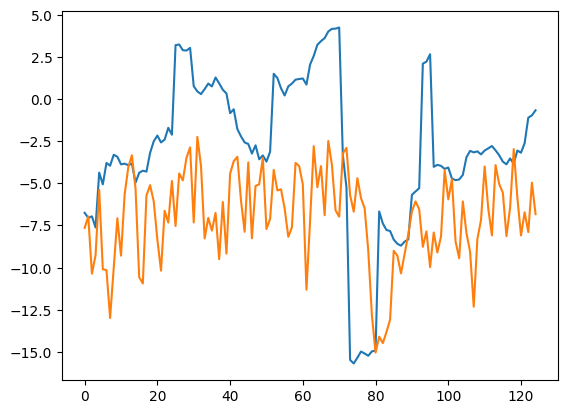

In [321]:
with torch.inference_mode():
    predicted = pair_model(X_test.to(device).to(torch.float32)).to(device)

true_y_test = scaler.inverse_transform(y_test)
true_y_pred = scaler.inverse_transform(predicted)

plt.plot(true_y_test, label = 'Actual Close')
plt.plot(true_y_pred, label = 'Predicted Close')

In [ ]:
#possibly add attention
#possibly change how layers of encoder to decoder are handled (possibly make different sizes)
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.input_dim = input_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=dropout)

    def forward(self, x):
        # x = [x length, batch size]
        outputs, hidden = self.rnn(x)
        # outputs = [x length, batch size, hidden dim]
        # hidden = [n layers, batch size, hidden dim]
        # cell = [n layers, batch size, hidden dim]
        # outputs are always from the top hidden layer
        return hidden
class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, 1)

    #predicts a single time step
    def forward(self, x, hidden):
        # input = [batch size]
        # hidden = [n layers, batch size, hidden dim]
        # cell = [n layers, batch size, hidden dim]
        x = x.unsqueeze(0)
        # input = [1, batch size]
        # embedded = [1, batch size, output dim]
        output, hidden = self.rnn(x, hidden)
        # output = [1, batch size, hidden dim]
        # hidden = [n layers, batch size, hidden dim]
        # cell = [n layers, batch size, hidden dim]
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch size, output dim]
        return prediction, self.dropout(hidden)
class EncoderDecoderWrapper(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        # might change if layers arent the same proves different results
        assert (
            encoder.hidden_dim == decoder.hidden_dim
        )
        assert (
            encoder.n_layers == decoder.n_layers
        )
    def forward(self, x, y=None):
        
        